In [1]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tools.eval_measures import rmse, medianabs


# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


env: PYTHONHASHSEED=0


# Baseline Forecasts for Cambridge UK Weather Time Series

Building baseline models for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).


I'm primarily interested in short term temperature forecasts (less than 2 hours) but will include results up to 24 hours in the future.

See previous work for further details:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)


## Import Data

The measurements are relatively noisy and there are usually several hundred missing values every year.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in April 2021 and occur every 30 mins.

Shape:
(225251, 7)

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 225251 entries, 2 to 225252
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ds                 225251 non-null  datetime64[ns]
 1   y                  225251 non-null  float64       
 2   humidity           225251 non-null  float64       
 3   dew.point          225251 non-null  float64       
 4   pressure           225251 non-null  float64       
 5   wind.speed.mean    225251 non-null  float64       
 6   wind.bearing.mean  225251 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.7 MB
None

Summary stats:


,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean
count,225251.000000,225251.000000,225251.000000,225251.000000,225251.000000,225251.000000
mean,10.027882,78.619532,58.600183,1014.342062,4.434737,194.974558
std,6.509969,17.308646,51.645273,11.911991,4.011087,82.876095
min,-7.000000,20.000000,-100.000000,963.000000,0.000000,0.000000
25%,5.200000,68.000000,19.000000,1008.000000,1.200000,135.000000
50%,9.600000,83.000000,59.100000,1016.000000,3.500000,225.000000
75%,14.500000,92.000000,97.000000,1022.000000,6.600000,270.000000
max,36.100000,100.000000,209.000000,1051.000000,29.200000,360.000000



Raw data:


,ds,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean
2,2008-08-01 00:30:00,19.5,65.75000,119.150000,1014.416667,1.150000,225.0
3,2008-08-01 01:00:00,19.1,49.75000,79.200000,1014.384615,1.461538,225.0
4,2008-08-01 01:30:00,19.1,66.17875,106.600000,1014.500000,1.508333,225.0
5,2008-08-01 02:00:00,19.1,58.50000,99.250000,1014.076923,1.430769,225.0
6,2008-08-01 02:30:00,19.1,66.95000,121.883333,1014.416667,1.133333,225.0
...,...,...,...,...,...,...,...
225248,2021-04-25 23:00:00,3.6,61.00000,-32.000000,1028.000000,1.400000,45.0
225249,2021-04-25 23:30:00,3.6,64.00000,-26.000000,1028.000000,2.600000,45.0
225250,2021-04-26 00:00:00,3.6,58.00000,-39.000000,1028.000000,4.300000,45.0
225251,2021-04-26 00:30:00,3.2,62.00000,-34.000000,1027.000000,5.400000,45.0


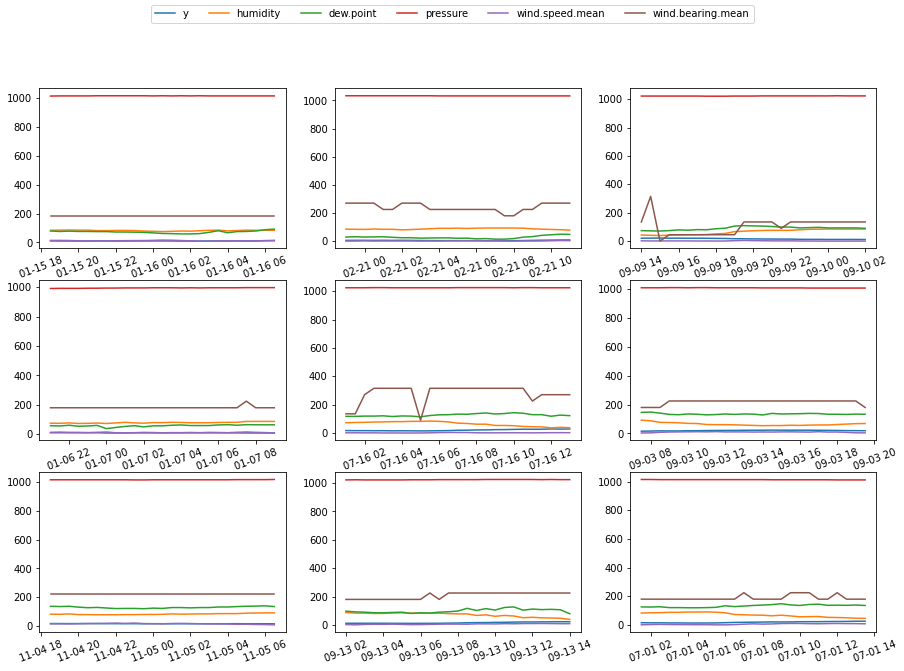

In [2]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanish2021.04.26.csv?raw=true"
else:
    data_loc = "../data/CamMetCleanish2021.04.26.csv"
df = pd.read_csv(data_loc, parse_dates = True)

df['ds'] = pd.to_datetime(df['ds'])
df['y'] = df['y'] / 10
df['wind.speed.mean'] = df['wind.speed.mean'] / 10

df = df.loc[df['ds'] > '2008-08-01 00:00:00',]

print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_examples(data, x_var):
    """Plot 9 sets of observations in 3 * 3 matrix ..."""

    assert len(data) == 9

    cols = [col for col in data[0].columns if col != x_var]

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
      for col in cols:
        axs[i].plot(data[i][x_var], data[i][col])
        axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


cols = ['ds', 'y', 'humidity', 'dew.point', 'pressure', 
        'wind.speed.mean', 'wind.bearing.mean']
plots  = 9
window = 24
starts = [random.randint(0, np.floor(df.shape[0] / window)) for _ in range(plots)]
p_data = [df.loc[starts[i] * window:starts[i] * window + window, cols] 
          for i in range(plots)]
plot_examples(p_data, 'ds')



---

## Data Processing and Feature Engineering

The data must be reformatted before model building.

The following steps are necessary:

 * Wind direction and speed transformation
 * Time conversion
 * Train test data separation
 * Normalise data?
 * Window data?

### Wind direction and speed transformation

The `wind.bearing.mean` column gives wind direction in degrees but is mostly categorised at 45 degree increments, i.e. 0, 45, 90, 135, 180, 225, 270, 315. Wind direction shouldn't matter if the wind is not blowing.

The distribution of wind direction and speed looks like this:

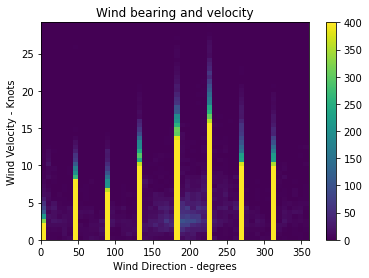

In [9]:
plt.hist2d(df['wind.bearing.mean'], df['wind.speed.mean'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind Direction - degrees')
plt.ylabel('Wind Velocity - Knots')
plt.title('Wind bearing and velocity');

Convert wind direction and speed to x and y vectors, so the model can more easily interpret them.

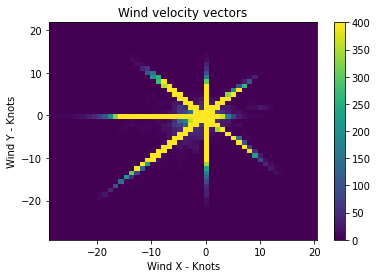

In [8]:
wv = df['wind.speed.mean']

# Convert to radians
wd_rad = df['wind.bearing.mean'] * np.pi / 180

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)

df_orig = df

plt.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X - Knots')
plt.ylabel('Wind Y - Knots')
plt.title('Wind velocity vectors');


Better, but not ideal. Data augmentation with the [mixup](https://arxiv.org/abs/1710.09412) method is carried out below.

From the paper: "mixup trains a neural network on convex combinations of pairs of examples and their labels".

Further details on how I apply mixup to time series are included in the Window data section of the [keras_mlp_fcn_resnet_time_series.ipynb notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb).

Here is an illustration of the improvement in wind velocity sparsity with mixup augmentation.

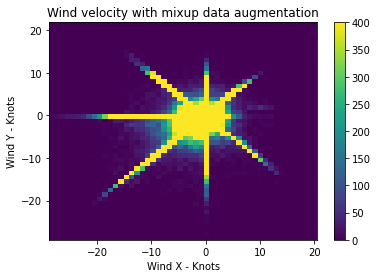

In [5]:
def mixup(data, alpha = 1.0, factor = 1):
    batch_size = len(data) - 1
    
    data['epoch'] = data.index.astype(np.int64) // 10**9
    
    # random sample lambda value from beta distribution
    l   = np.random.beta(alpha, alpha, batch_size * factor)
    X_l = l.reshape(batch_size * factor, 1)
    
    # Get a pair of inputs and outputs
    y1  = data['y'].shift(-1).dropna()
    y1_ = pd.concat([y1] * factor)
    
    y2  = data['y'][0:batch_size]
    y2_ = pd.concat([y2] * factor)

    X1  = data.drop('y', 1).shift(-1).dropna()
    X1_ = pd.concat([X1] * factor)
    
    X2  = data.drop('y', 1)
    X2  = X2[0:batch_size]
    X2_ = pd.concat([X2] * factor)

    # Perform mixup
    X = X1_ * X_l + X2_ * (1 - X_l)
    y = y1_ * l   + y2_ * (1 - l)    
    
    df = pd.DataFrame(y).join(X)    
    df = data.append(df).sort_values('epoch', ascending = True)
    df = df.drop('epoch', 1)
    
    df = df.drop_duplicates(keep = False)
    
    return df


df_mix = mixup(df.loc[:, ['y','wind.x','wind.y']], factor = 2)
plt.hist2d(df_mix['wind.x'], df_mix['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X - Knots')
plt.ylabel('Wind Y - Knots')
plt.title('Wind velocity with mixup data augmentation');

Mixup improves the categorical legacy of the wind velocity data. Unfortunately, if outliers are present their influence will likely be reinforced.

For now, I'm not using mixup with any of the baseline methods.  See the [keras_mlp_fcn_resnet_time_series.ipynb notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb) for an illustration of the profoundly beneficial improvement mixup provides with this dataset.

---

### Time conversion

Convert `ds` timestamps to "time of day" and "time of year" variables using `sin` and `cos` functions.

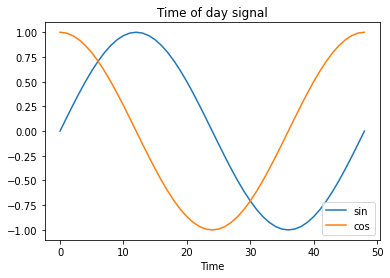

In [6]:
# Convert to secs
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = (365.2425) * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['day.sin'])[49:98])
plt.plot(np.array(df['day.cos'])[49:98])
plt.xlabel('Time')
plt.legend(['sin', 'cos'], loc = 'lower right')
plt.title('Time of day signal');

The yearly time components may benefit from a single phase shift so they align with the seasonal temperature peak around the end of July and temperature trough around the end of January.  Similarly, the daily components may benefit from small daily phase shifts.

For now, I'm not using these time components with the baseline methods.

---

### Split data¶

I use data from 2018 for validation, 2019 for testing and the remaining data for training. These are entirely arbitrary choices. This results in an approximate 84%, 8%, 8% split for the training, validation, and test sets respectively.

df.drop shape:  (225251, 13)
train shape:    (190023, 13)
valid shape:    (17655, 13)
test shape:     (17573, 13)


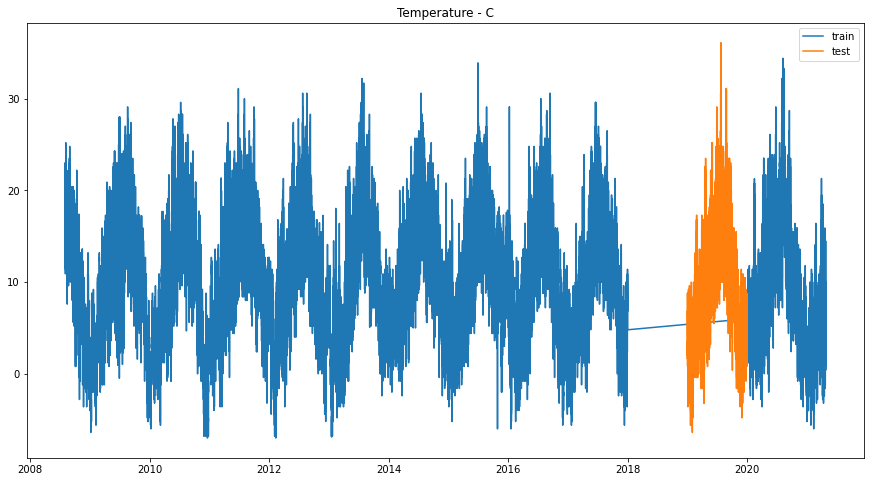

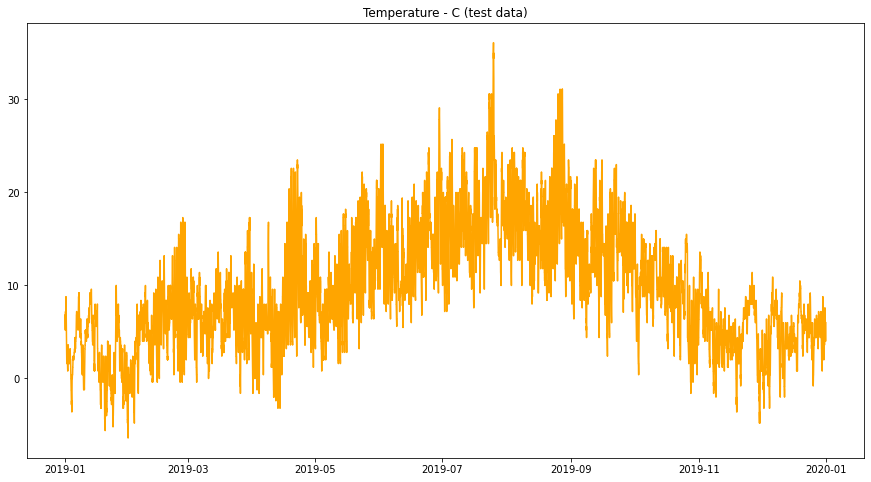

In [7]:
keep_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',
             'day.sin', 'day.cos', 'year.sin', 'year.cos', 'ds']

df['year'] = df['ds'].dt.year
train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]

train_df = train_df.drop('year', axis = 1)  # inplace = True gives SettingWithCopyWarning
valid_df = valid_df.drop('year', axis = 1)  # ...
test_df  = test_df.drop('year',  axis = 1)
df       = df.drop('year',       axis = 1)

print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)

plt.figure(figsize = (15, 8))
plt.plot(train_df.ds, train_df.y)
plt.plot(test_df.ds,   test_df.y)
plt.title('Temperature - C')
plt.legend(['train', 'test'])
plt.show()

plt.figure(figsize = (15, 8))
plt.plot(test_df.ds, test_df.y, color='orange')
plt.title('Temperature - C (test data)')
plt.show();

The training data is used to calculate the seasonal average values.

---

## Baselines Methods

This notebook is being developed on [Google Colab](https://colab.research.google.com) primarily with the [statsmodels](https://www.statsmodels.org/) package.

I will not use complicated methods just for comparison of baseline methods. Also, I don't want to spend a great deal of time optimising hyperparameter settings.  This means I will use simpler methods and default settings as far as possible.

Model diagnostics will not be checked.  Some of the models built may have issues.

Runtime may become an issue for complicated methods.

Univariate baseline methods:
 * mean - simple average
 * naive - persistent
 * seasonal average - historical average
 * SES - Simple Exponential Smoothing
 * HWES - Holt Winter's Exponential Smoothing

I would also like to look at results from, the [AutoReg](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg) and [STL](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html) functions but they are unavailable in the current version of statsmodels (0.10.2) installed on Google Colab (as of 28/04/21).  The alternative [AR](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.html#statsmodels.tsa.ar_model.AR) function is depracated.  ARIMA models would be the next logical choice but often require model checking and tuning.  Installing packages on Google Colab is straight-forward.  Upgrading packages may also be straight-forward, but it's probably more productive to move onto multi-variate baselines instead.

Multivariate baseline methods:
 * VAR?
 * SARIMAX?

...

Forecast horizons:
  * next 30 mins - 1 step ahead
  * next 2 hours - 4 steps ahead
  * next 24 hours - 48 steps ahead

Some forecast methods are limited to single step forecasts, i.e. no multi-step forecasts.  For example, simple average and seasonal average.

...

Metrics:
 * rmse
 * mae
 * mape?

...

---

### Univariate Baseline Methods

Firstly, the mean baseline:

In [64]:
# sa - simple average
sa = train_df.y.mean()
rmse_sa = rmse(test_df.y, sa)
mae_sa  = medianabs(test_df.y, sa)

print("simple average:", round(sa, 2))
print("rmse:", round(rmse_sa, 2))
print("mae: ", round(mae_sa,  2))

cols = ['type', 'method', 'metric', 'horizon', 'value']
metrics_h = []  # h for horizon

for i in range(1, 49):
  metrics_h.append(dict(zip(cols, ['univariate', 'mean', 'rmse', i, rmse_sa])))
  metrics_h.append(dict(zip(cols, ['univariate', 'mean',  'mae', i,  mae_sa])))

metrics = pd.DataFrame(metrics_h, columns = cols)

simple average: 10.09
rmse: 6.42
mae:  4.89


The mean baseline has equivalent metric values across all forecast horizons.

---

Secondly, the naive baseline:


h	rmse	mae
1 	 0.66 	 0.4
4 	 1.86 	 0.9
48 	 3.08 	 2.0




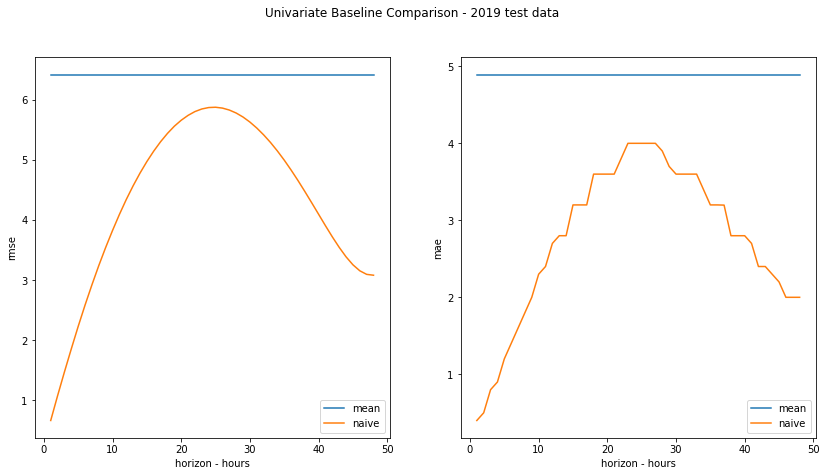

In [65]:
def get_naive_metrics(data, horizon, method):
  y_hat = data.copy()
  y_hat['naive'] = y_hat.y.shift(horizon)
  y_hat = y_hat.iloc[horizon:]  # remove na value
  naive_rmse = rmse(y_hat.y, y_hat.naive)
  naive_mae  = medianabs(y_hat.y, y_hat.naive)
  
  return [naive_rmse, naive_mae]


def plot_metrics(metrics, main_title):
  fig, axs = plt.subplots(1, 2, figsize = (14, 7))
  fig.suptitle(main_title)
  axs = axs.ravel()  # APL ftw!

  methods = metrics.method.unique()

  for method in methods:
    df = metrics.query('metric == "rmse" & method == "%s"' % method)
    axs[0].plot(df.horizon, df.value)
  axs[0].set_xlabel("horizon - hours")
  axs[0].set_ylabel("rmse")
  axs[0].legend(methods)

  for method in methods:
    df = metrics.query('metric == "mae" & method == "%s"' % method)
    axs[1].plot(df.horizon, df.value)
  axs[1].set_xlabel("horizon - hours")
  axs[1].set_ylabel("mae")
  axs[1].legend(methods);


def update_metrics(metrics, test_data, method, get_metrics, model=None):
  metrics_h = []

  if method in ['SES', 'HWES']:
    horizons = [i for i in range(4, 49, 4)]
    horizons.insert(0, 1)
  else:
    horizons = range(1, 49)

  if method in ['VAR', 'SARIMAX']:
    variates = 'multivariate'
  else:
    variates = 'univariate'

  print("h\trmse\tmae")
  for h in horizons:
    if method in ['VAR', 'SARIMAX']:
      rmse_h, mae_h = get_metrics(test_df, h, method, model)
    else:
      rmse_h, mae_h = get_metrics(test_df, h, method)

    metrics_h.append(dict(zip(cols, [variates, method, 'rmse', h, rmse_h])))
    metrics_h.append(dict(zip(cols, [variates, method,  'mae', h,  mae_h])))
    
    if h in [1, 4, 48]:
      print(h, "\t", round(rmse_h, 2), "\t", round(mae_h, 2))

  print("\n")

  metrics_method = pd.DataFrame(metrics_h, columns = cols)
  metrics = metrics.append(metrics_method)

  return metrics


metrics = update_metrics(metrics, test_df, 'naive', get_naive_metrics)
plot_metrics(metrics, "Univariate Baseline Comparison - 2019 test data")

Obviously, the naive method is an improvement over the simple average.

The daily seasonality is clearly evident in the naive method.

---

Third, seasonal average:

rmse: 4.65
mae:  2.97


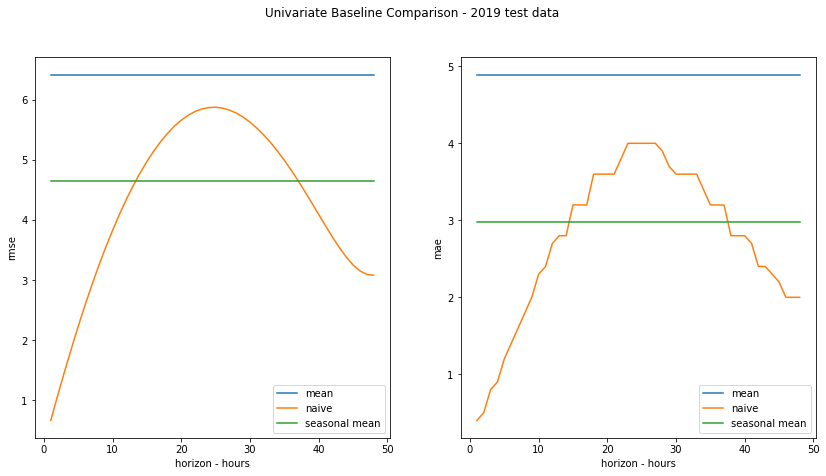

In [66]:
train_df['doy'] = train_df.ds.dt.strftime('%j')
train_df['hms'] = train_df.ds.dt.strftime('%H:%M:%S')

# ha - historical average
ha = pd.DataFrame(train_df.groupby(['doy', 'hms']).y.mean())
ha.reset_index(inplace=True)  

rmse_ha = rmse(test_df.y[:17568],      ha.y)
mae_ha  = medianabs(test_df.y[:17568], ha.y)

print("rmse:", round(rmse_ha, 2))
print("mae: ", round(mae_ha,  2))

metrics_h = []  # h for horizon

for h in range(1, 49):
  metrics_h.append(dict(zip(cols, ['univariate', 'seasonal mean', 'rmse', h, rmse_ha])))
  metrics_h.append(dict(zip(cols, ['univariate', 'seasonal mean',  'mae', h,  mae_ha])))

metrics_ha = pd.DataFrame(metrics_h, columns = cols)
metrics = metrics.append(metrics_ha)

plot_metrics(metrics, "Univariate Baseline Comparison - 2019 test data")

The historical average, or seasonal average, is superior to the simple average.  It also illustrates how the naive method is struggling with the daily seasonality component.

---

Fourth, simple exponential smoothing:
 * Run time is getting quite long
   * I run every 4th horizon value
   * Still takes approx. 15 mins
 * Default settings for `SimpleExpSmoothing` function
 * Using 24 for the initial training window

h	rmse	mae
1 	 0.44 	 0.44
4 	 1.02 	 0.9
48 	 4.0 	 3.23
CPU times: user 15min 53s, sys: 22.1 s, total: 16min 15s
Wall time: 15min 48s


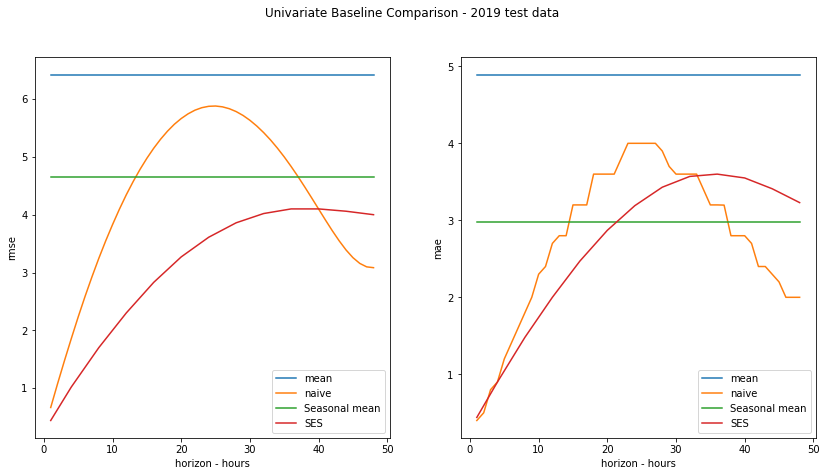

In [42]:
%%time

def es_rolling_cv(data, horizon, method):
    i =  0
    x = 48  # initial training window
    h = horizon
    rmse_roll, mae_roll = [], []

    while (i + x + h) < len(data):
        train_ts = data[(i):(i + x)].y.values
        test_ts  = data[(i + x):(i + x + h)].y.values
        # print("train:", train_ts, "\ntest:", test_ts)  # DEBUG

        if method == 'SES':
          model_roll = SimpleExpSmoothing(train_ts).fit()
        elif method == 'HWES':
          model_roll = ExponentialSmoothing(train_ts,
                                            seasonal_periods = 48,
                                            seasonal = 'add',
                                            ).fit()

        y_hat = model_roll.forecast(h)
        # print("yhat:", y_hat)  # DEBUG

        rmse_i = rmse(test_ts, y_hat)
        mae_i  = medianabs(test_ts, y_hat)
        # print("rmse:", rmse_i, "\nmae:", mae_i, "\n")  # DEBUG
        rmse_roll.append(rmse_i)
        mae_roll.append(mae_i)

        i = i + 1
   
    return [np.mean(rmse_roll).round(2), np.mean(mae_roll).round(2)]


metrics = update_metrics(metrics, test_df, 'SES', es_rolling_cv)
plot_metrics(metrics, "Univariate Baseline Comparison - 2019 test data")

Clearly, the SES method is an improvement over the naive method for forecast horizons less than approx. 18 hours.

It may be possible to optimise the SES method by setting initial training window length `train_window` and/or the `initialization_method` parameter.  See [statsmodels docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html) for `initialization_method` options.

---

Fifth, Holt-Winters exponential smoothing:
 * Run time is getting quite long
   * I run every 4th horizon value
   * Still takes approx. 30 mins
 * `seasonal_periods` is set to 48 (24 half-hourly observations)
   * yearly seasonality is not accounted for
   * `ExponentialSmoothing` function does not support multiple seasonalities
 * `seasonal` is set to additive
 * Temperature measurements are mostly cyclic with little or no trend across the years
   * `trend` and `damped_trend` are set to default values of `None`


h	rmse	mae


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:924: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:929: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:930: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)


1 	 2.43 	 2.43
4 	 2.5 	 2.42
48 	 2.8 	 2.24
CPU times: user 32min 26s, sys: 38.5 s, total: 33min 5s
Wall time: 32min 27s


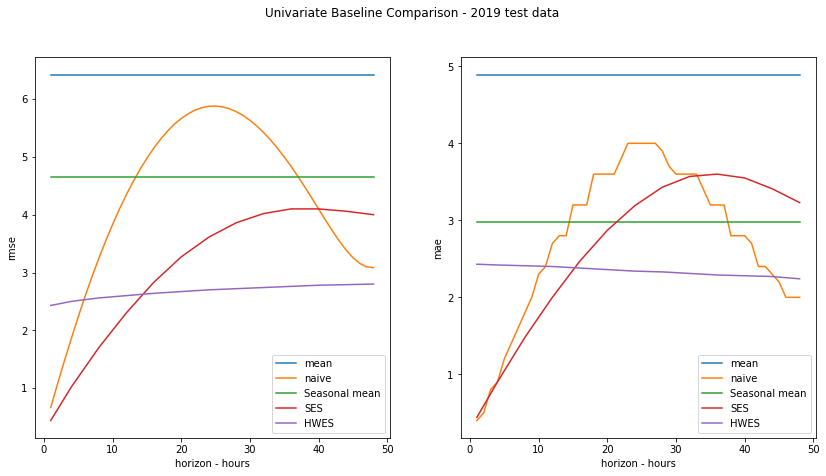

In [43]:
%%time

metrics = update_metrics(metrics, test_df, 'HWES', es_rolling_cv)
plot_metrics(metrics, "Univariate Baseline Comparison - 2019 test data")

On the whole, HWES is an improvement over the other methods even if short horizon forecasts are worse.

The daily cyclic component in the naive and SES methods is no longer an issue with the HWES as we would expect.

It's puzzling that the mean absolute error decreases slightly as the horizon increases.  Adding error bars may partially address this issue.

It's also worth noting:
 * There are convergence warnings if the initial training window is not equal to the seaonality period of 48
 * Opportunities for HWES parameter tuning include the `use_boxcox` and `initialization_method` options

---


### Multivariate Baseline Methods

...

Firstly, VAR:
 * not using `wind.x` or `wind.y` in model
 * only calculating rmse and mae for y (temperature)
 * using sinusoidal time variable as exogenous data
 * ...


In [58]:
# %%time

from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 12
test   = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]

    return df


vars = ['y', 'humidity', 'dew.point', 'pressure'] #, 
        #'wind.x', 'wind.y']

gcm = grangers_causation_matrix(test_df, vars)
display(gcm)  


var_df = test_df[vars].head(5000)
exog_df = test_df[['day.cos', 'day.sin', 'year.cos', 'year.sin']].head(5000)
# print(var_df.shape)
exog_fut = test_df[['day.cos', 'day.sin', 'year.cos', 'year.sin']].head(5004).tail(4)

model = VAR(endog = var_df, exog = exog_df)
model_fit = model.fit(maxlags = 12, ic = 'aic')
#model_fit = model.fit(12)

print(model_fit.summary())

# make prediction on validation
preds = model_fit.forecast(model_fit.endog, exog_future = exog_fut, steps = 4)

display(test_df[vars].head(5004).tail(10))
display(preds)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,y_x,humidity_x,dew.point_x,pressure_x
y_y,1.0,0.0000,0.0,0.0
humidity_y,0.0,1.0000,0.0,0.0
dew.point_y,0.0,0.0000,1.0,0.0
pressure_y,0.0,0.0017,0.0,1.0


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, May, 2021
Time:                     19:33:51
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    3.36250
Nobs:                     4991.00    HQIC:                   3.22346
Log likelihood:          -36020.6    FPE:                    23.2991
AIC:                      3.14841    Det(Omega_mle):         22.5490
--------------------------------------------------------------------
Results for equation y
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -1.896029         0.534693           -3.546           0.000
exog0               -0.166846         0.012531          -13.315           0.000
exog1                0.067898         0.011938            5.687     

,y,humidity,dew.point,pressure
189523,0.8,85.0,-14.0,1027.0
189524,0.4,86.0,-17.0,1027.0
189525,0.4,87.0,-15.0,1026.0
189526,0.4,89.0,-12.0,1026.0
189527,0.4,94.0,-5.0,1026.0
189528,0.4,92.0,-7.0,1025.0
189529,0.8,81.0,-21.0,1025.0
189530,0.8,94.0,-1.0,1025.0
189531,1.6,92.0,4.0,1025.0
189532,1.6,93.0,6.0,1024.0


array([[ 5.54613369e-01,  9.09283439e+01, -7.65313431e+00,
         1.02496658e+03],
       [ 7.18643915e-01,  9.08741482e+01, -6.17245669e+00,
         1.02471200e+03],
       [ 9.62652642e-01,  9.01088610e+01, -5.26849255e+00,
         1.02441990e+03],
       [ 1.19996638e+00,  8.93059310e+01, -4.73448043e+00,
         1.02414703e+03]])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, May, 2021
Time:                     22:30:54
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    4.73778
Nobs:                     190011.    HQIC:                   4.73039
Log likelihood:      -1.52738e+06    FPE:                    112.990
AIC:                      4.72730    Det(Omega_mle):         112.874
--------------------------------------------------------------------
Results for equation y
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -2.790509         0.140311          -19.888           0.000
L1.y                  1.026842         0.003213          319.609           0.000
L1.humidity          -0.011483         0.000595          -19.289

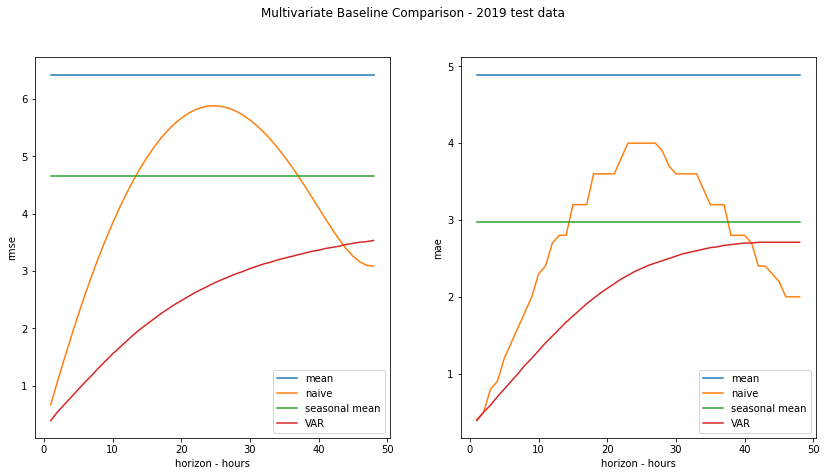

In [103]:
%%time

# build model on train_df
endo_vars = ['y', 'humidity', 'dew.point', 'pressure'] # better model without wind.x & wind.y
exog_vars = ['day.cos', 'day.sin', 'year.cos', 'year.sin']
endo_df = train_df[endo_vars]
exog_df = train_df[exog_vars]

# var_model = VAR(endog = endo_df, exog = exog_df)
var_model = VAR(endog = endo_df)
var_fit   = var_model.fit(maxlags = 12, ic = 'aic')
print(var_fit.summary())


# rolling_cv with pre-trained model
def var_rolling_cv(data, horizon, method, model):
    lags = model.k_ar  # lag order
    i = lags
    h = horizon
    rmse_roll, mae_roll = [], []
    endo_vars = ['y', 'humidity', 'dew.point', 'pressure']
    exog_vars = ['day.cos', 'day.sin', 'year.cos', 'year.sin']
    # print("\ti:", i, "\th:", h, "\tlags:", lags)  # DEBUG

    while (i + h) < len(data):
        # test_ts = data[i:(i + h)]
        test_df = data[endo_vars].iloc[i:(i + h)]
        endo_df = data[endo_vars].iloc[(i - lags):i].values
        exog_df = data[exog_vars].iloc[i:(i + h)]
        #exog_df = data[exog_vars].iloc[(i - lags):i]
        #exog_df = data[exog_vars].iloc[i:(i + h)]
        # endo_df = data.loc[(i - lags):i, endo_vars]
        # exog_df = data.loc[i:(i + h),    exog_vars]
        #print("\tendo:", endo_df.shape, "\texog:", exog_df.shape)  # DEBUG
        # display(endo_df)  # DEBUG

        # y_hat = model.forecast(y = endo_df, exog_future = exog_df, steps = h)
        y_hat = model.forecast(endo_df, steps = h)
        # print("yhat:", y_hat)  # DEBUG

        preds = pd.DataFrame(y_hat, index = range(0, len(y_hat)), columns = [endo_vars])

        #display(y_hat[:, 0])
        #display(preds)
        #display(preds[0])
        #display(preds.y)
        #display(preds['y'])
        #display(test_df.y)
        rmse_i = rmse(test_df.y, y_hat[:, 0])
        mae_i  = medianabs(test_df.y, y_hat[:, 0])
        # print("rmse:", rmse_i, "\nmae:", mae_i, "\n")  # DEBUG
        rmse_roll.append(rmse_i)
        mae_roll.append(mae_i)

        i = i + 1
   
    return [np.mean(rmse_roll).round(2), np.mean(mae_roll).round(2)]


metrics = update_metrics(metrics, test_df, 'VAR', var_rolling_cv, var_fit)
plot_metrics(metrics, "Multivariate Baseline Comparison - 2019 test data")

...


---


## Conclusion

Fortunately ...

Univariate methods:
 * Brief summary
 * Best method ...

Multi-variate methods:
 * Brief summary
 * Best method ...

Univariate vs multivariate methods

On an unrelated matter ...

Future work:
 * add error bars, confidence intervals etc
 * other methods
   * upgrade statsmodels on Google Colab
   * check [AutoReg](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg) and [STL](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html) performance
   * install [sktime](https://www.sktime.org/en/latest/)
     * [TBATS](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.tbats.TBATS.html) implementation supports multiple seasonalities
   * machine learning methods
     * Gaussian processes
     * LSTM
 * ...

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]

IPython version:
5.5.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
statsmodels,0.10.2
pandas,1.1.5
numpy,1.19.5
matplotlib,3.2.2


In [ ]:
!date

Thu Apr 22 20:52:55 UTC 2021


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "cammet_baselines_2021.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}